In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of research.orderbook_strategies.utils.factors failed: Traceback (most recent call last):
  File "/opt/miniconda3/envs/vnpy3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/opt/miniconda3/envs/vnpy3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/miniconda3/envs/vnpy3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/opt/miniconda3/envs/vnpy3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/opt/miniconda3/envs/vnpy3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


In [ ]:
import os
os.chdir("/Users/bytedance/MLTrader-deploy/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')

product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

In [ ]:
# factor = factors.foctor_nr_period()
# # %%time
# # 构造因子
# factor = factors.foctor_atr_period()
# for product in product_list:
#     file_list = helper.get_dates_list(product)
#     helper.parLapply(file_list, 
#                         factor_analysis.build_composite_signal,
#                         signal_list=[factor], 
#                         product=product)

In [ ]:
# 脚本现在开始
periods = [64, 128, 512, 1024, 2048, 4096]
signal_name_format = 'trend.index.{period}'

In [ ]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

In [ ]:
# # 需要验证这个是否和pnl成正比
# for period in [64, 128, 512, 1024, 2048, 4096]
#     for product in product_list:
#         T = len(all_product_signal[product])
#         arr = all_product_signal[product]
#         ret = tick_ret[product]
#         ret = pd.Series(ret).rolling(period).sum().shift(-period).values  # period return
#         lower, higher = np.quantile(arr, [0.1, 0.9])
#         mask = (arr <= lower) | (arr >= higher)
#         df = pd.DataFrame({"signal": arr[mask], "ret": ret[mask]})
#         corr = df.corr().iloc[0, 1].item()
#         print(f"{product} corr: {corr: .4%}")
    

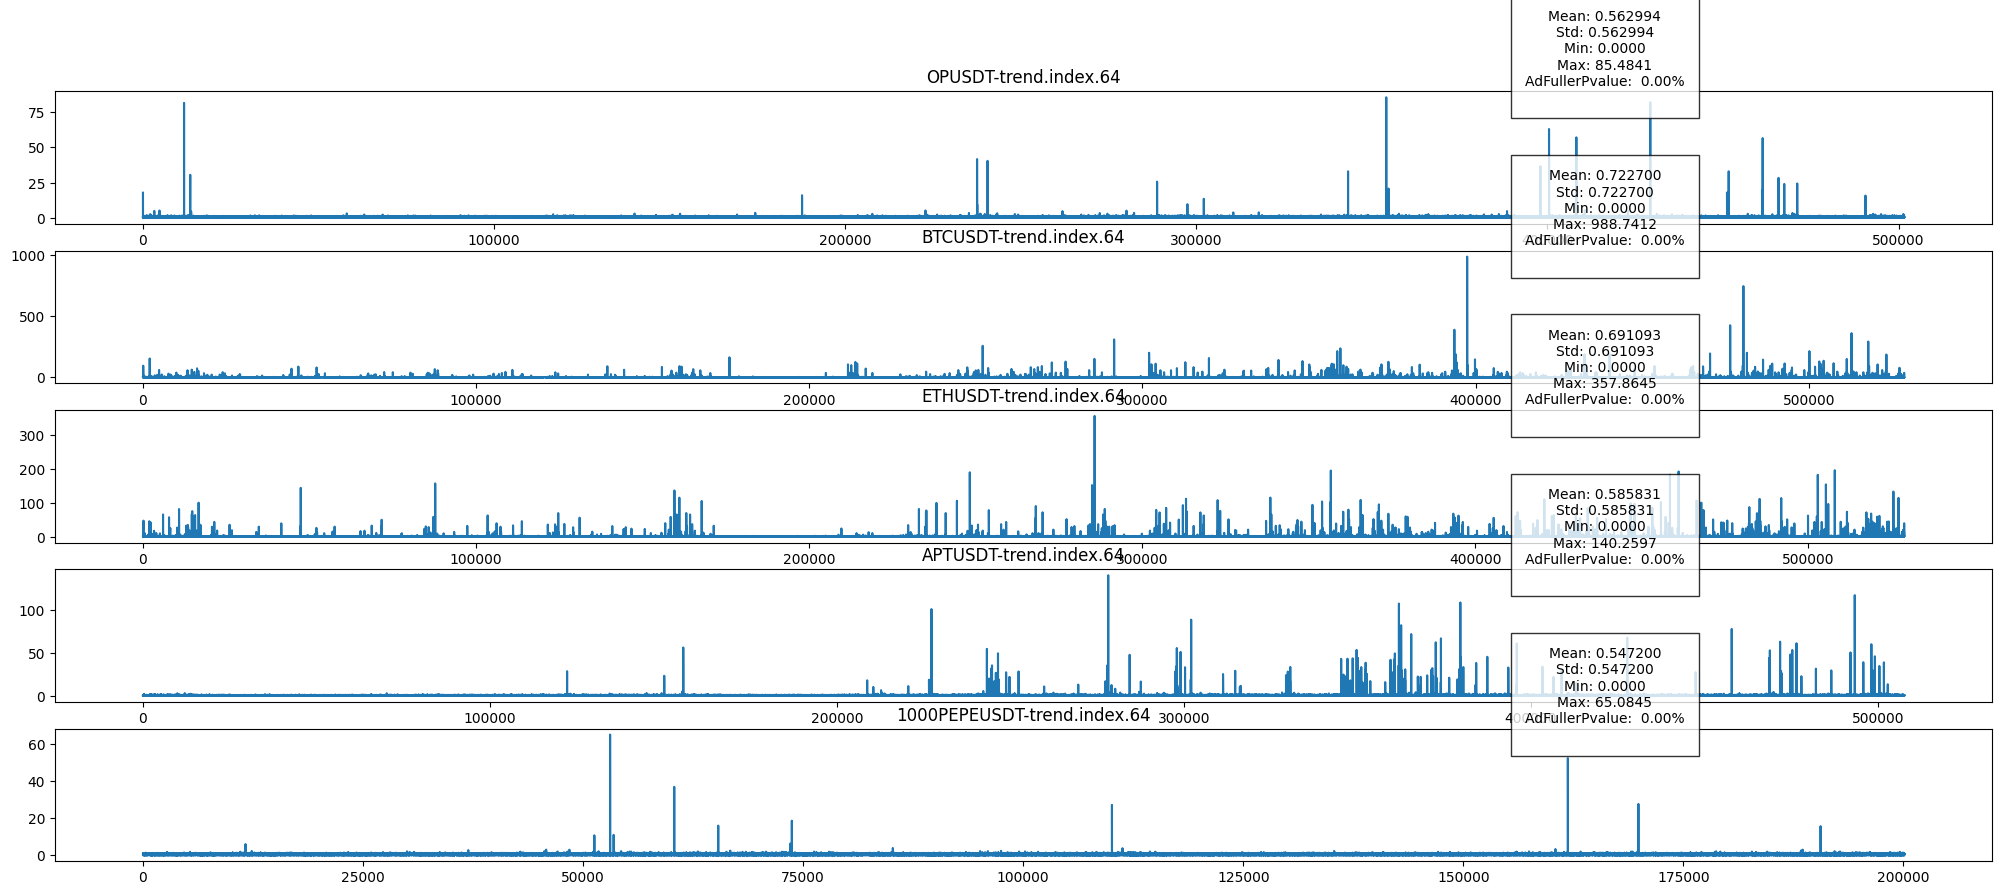

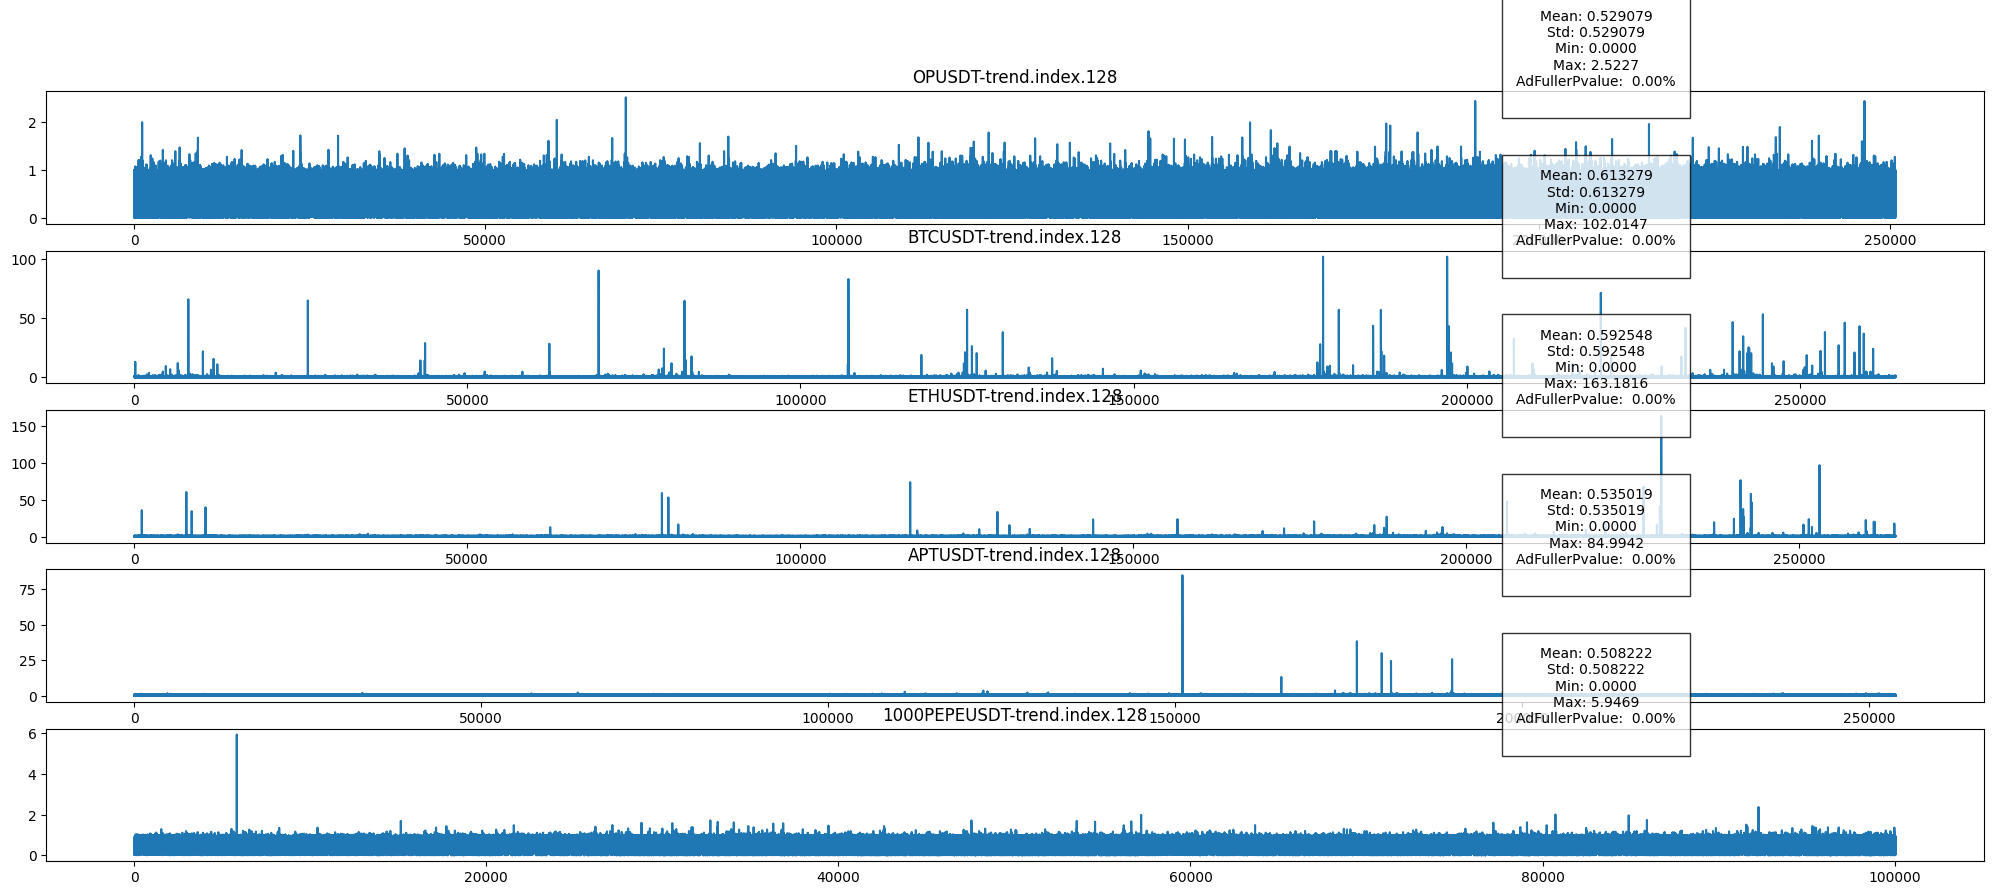

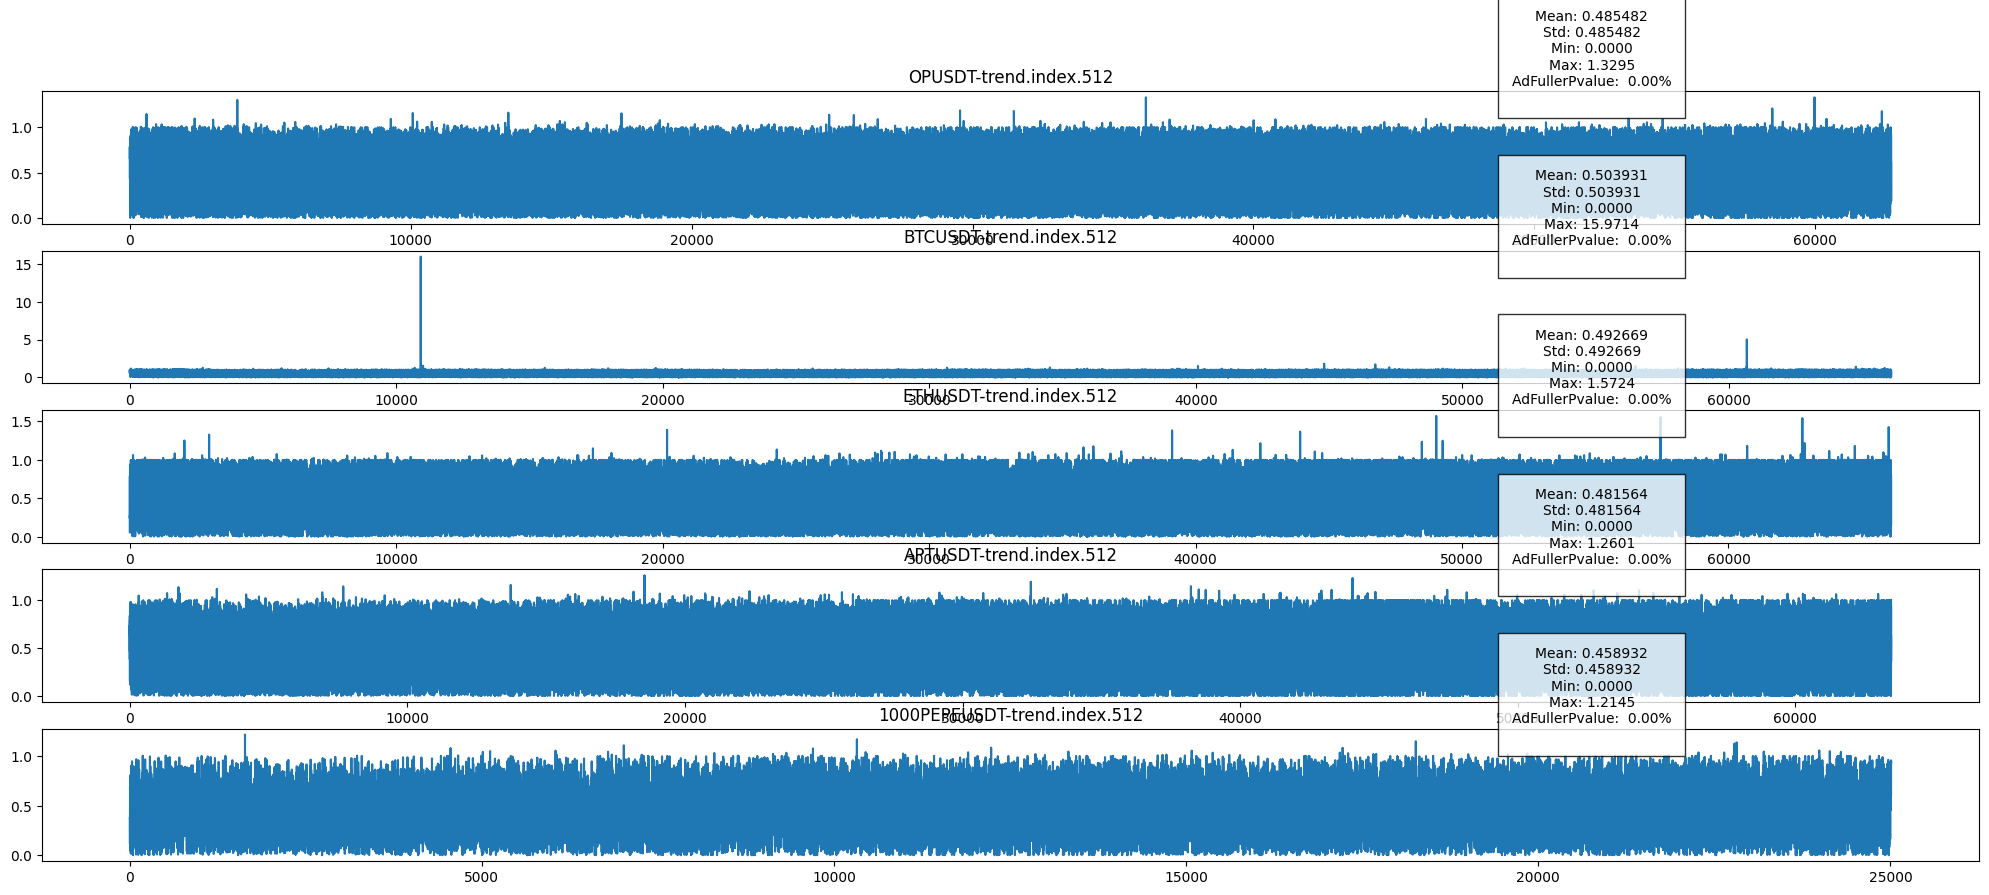

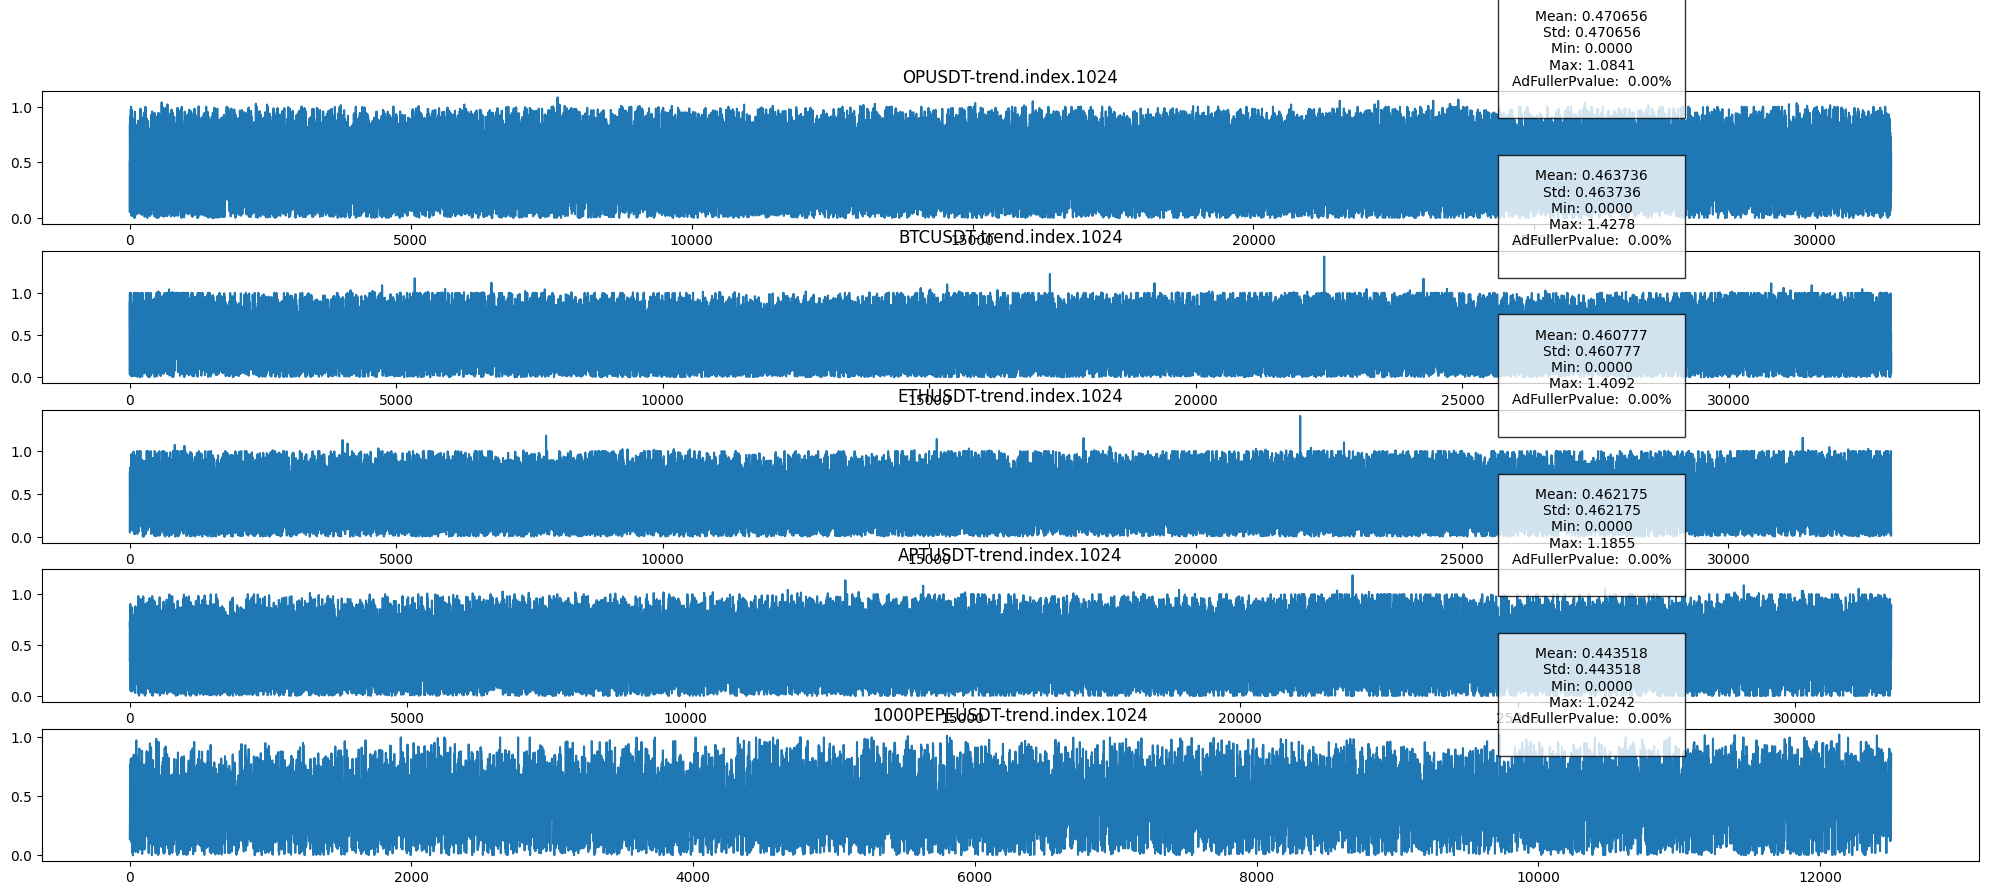

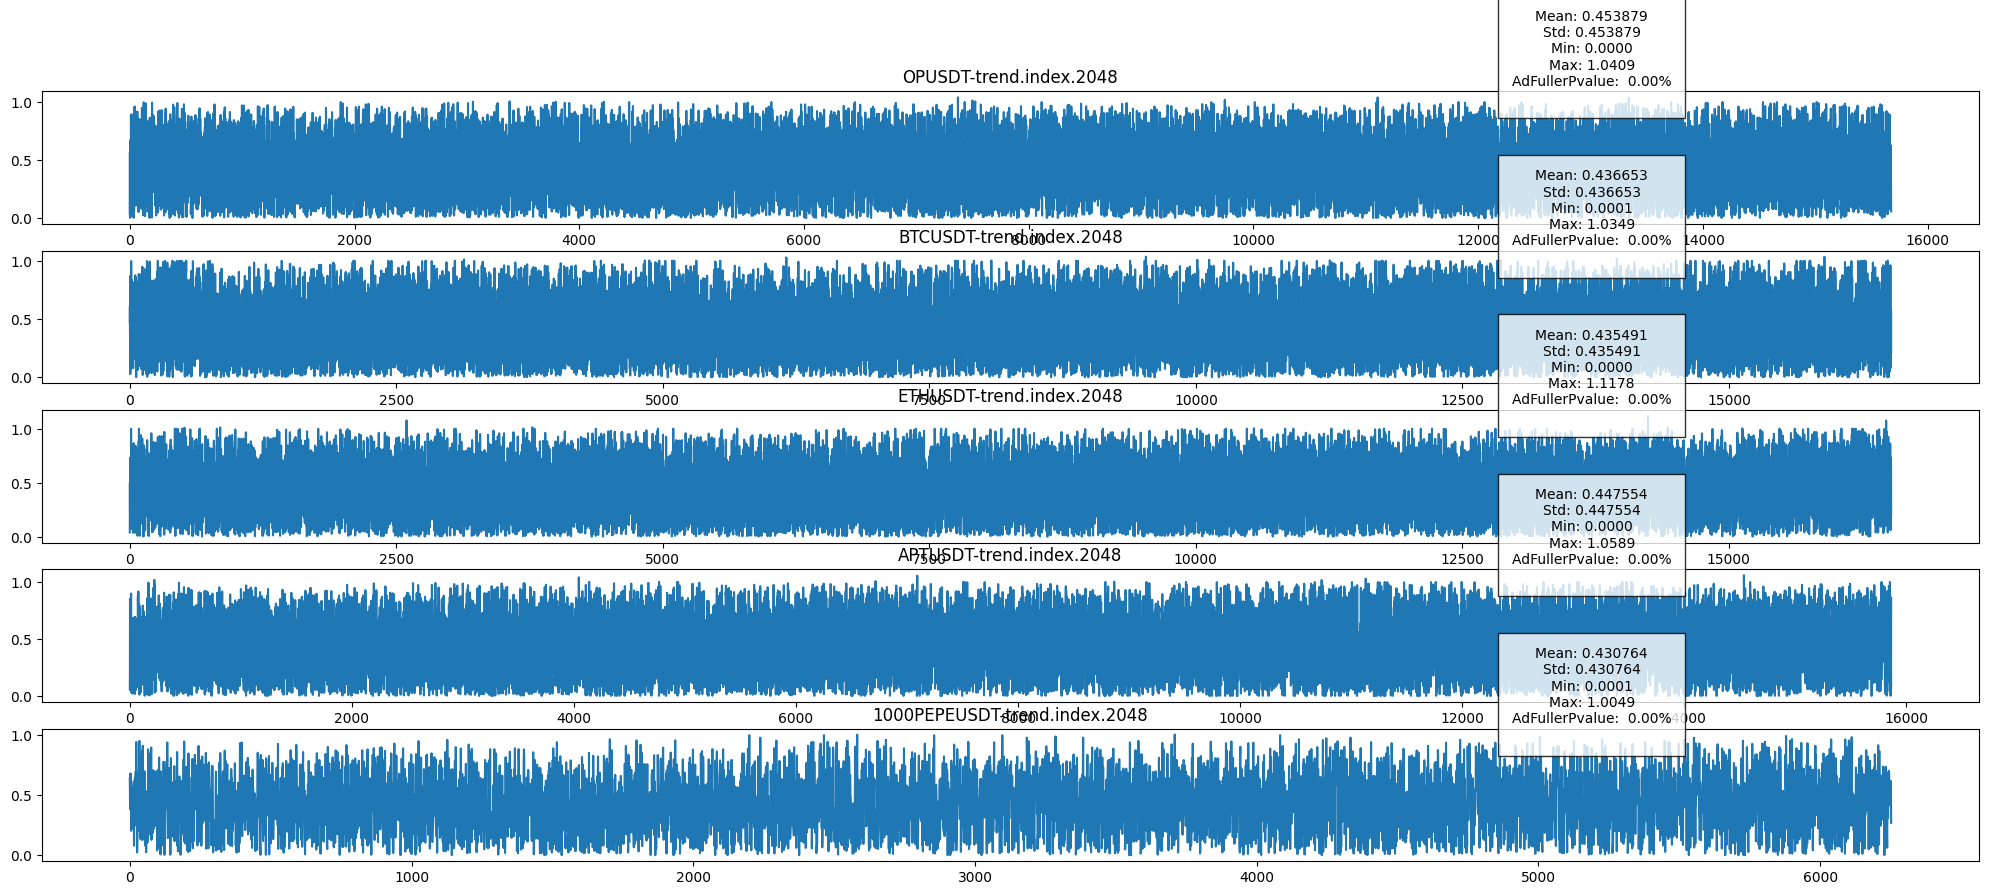

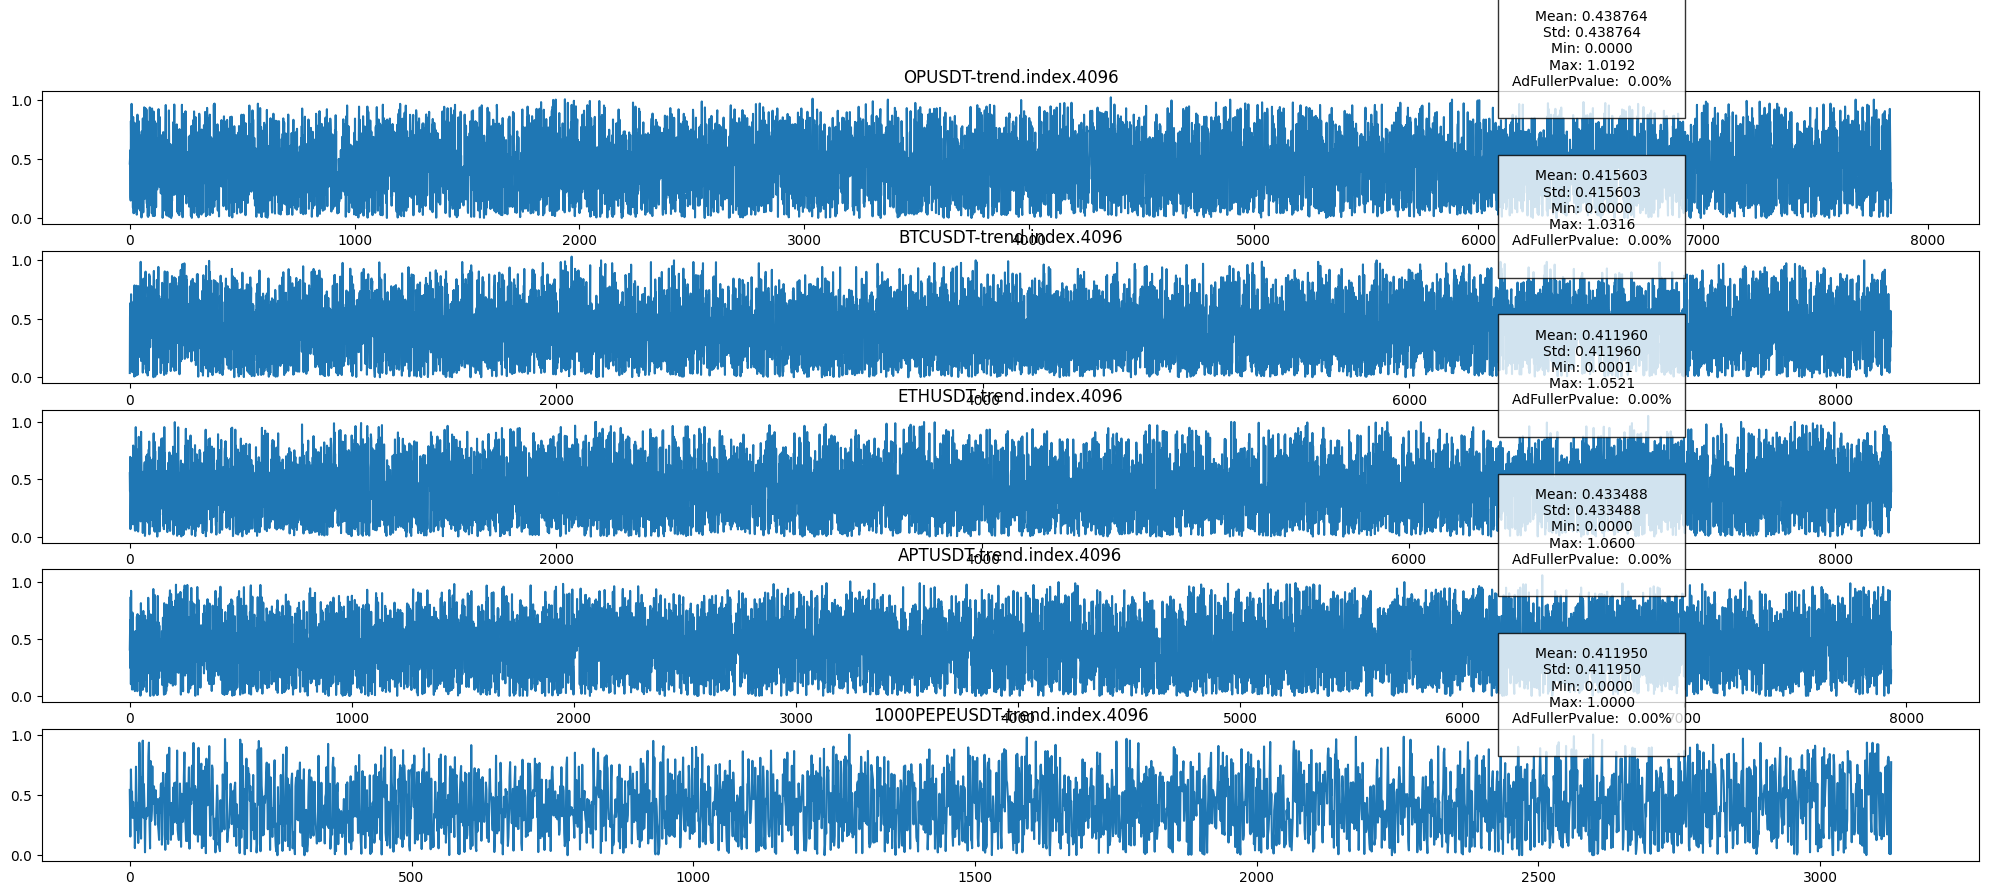

In [ ]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)
        # ret = tick_ret[product]
        # ret = pd.Series(ret).rolling(period).sum().shift(-period).values  # period return
        # lower, higher = np.quantile(arr, [0.1, 0.9])
        # mask = (arr <= lower) | (arr >= higher)
        # df = pd.DataFrame({"signal": arr[mask], "ret": ret[mask]})
        # corr = df.corr().iloc[0, 1].item()
        
        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

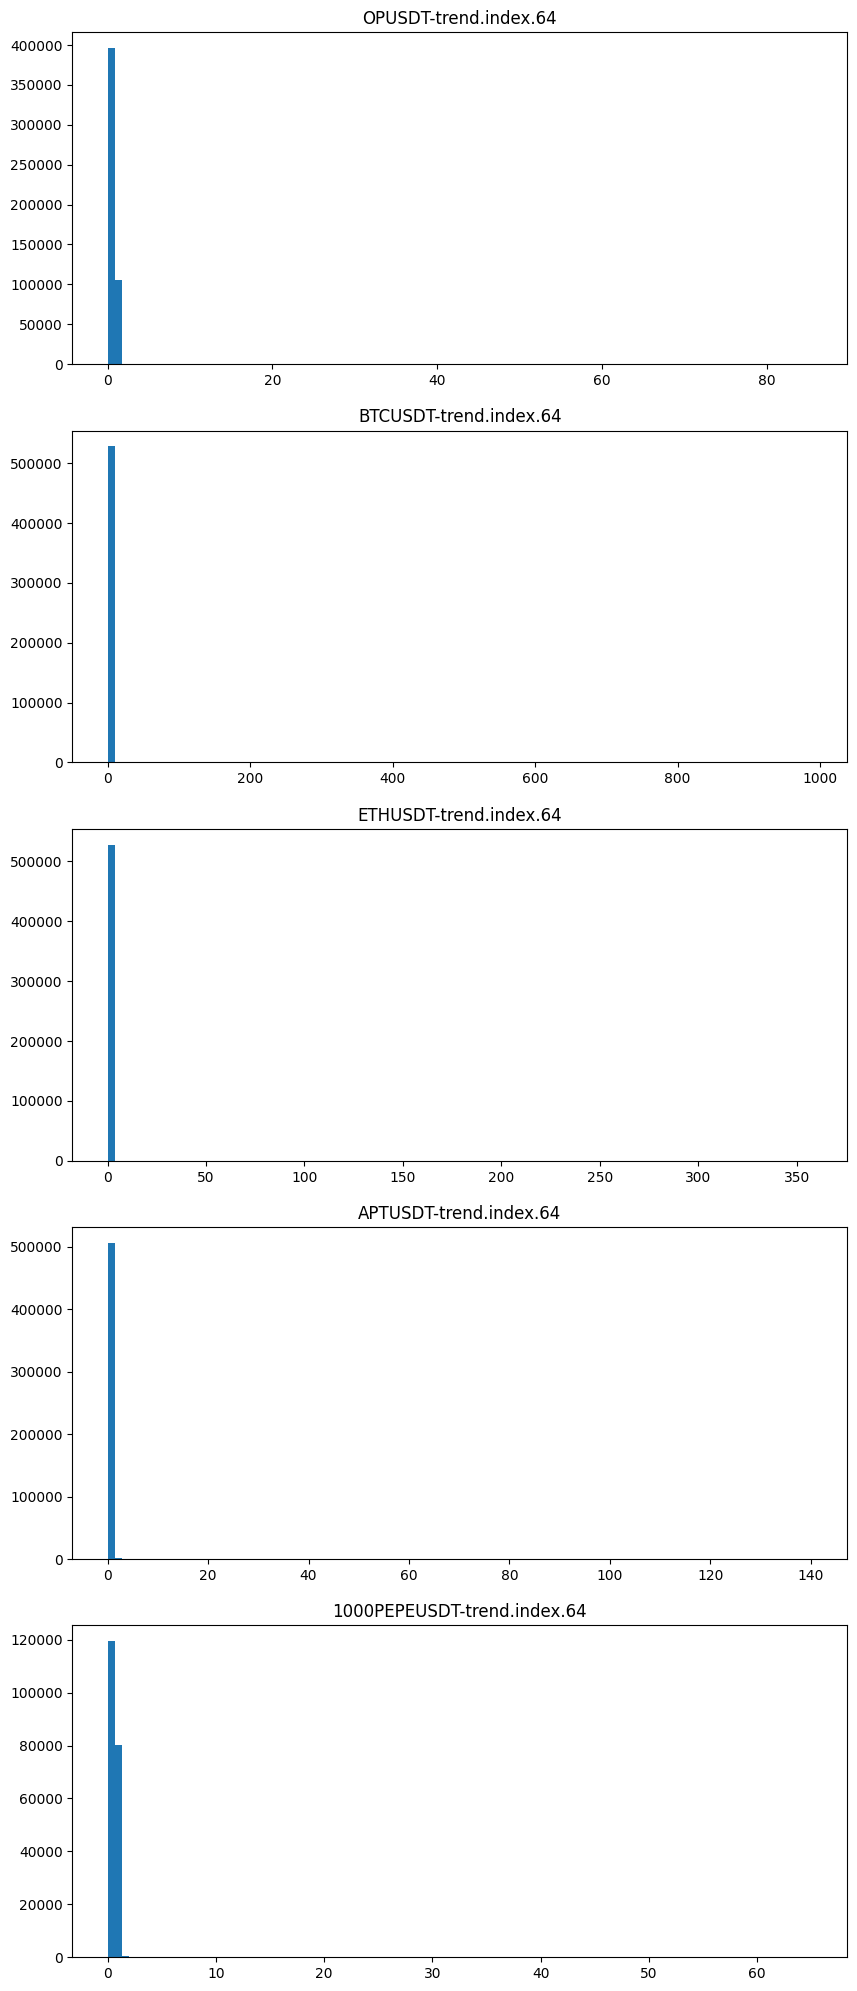

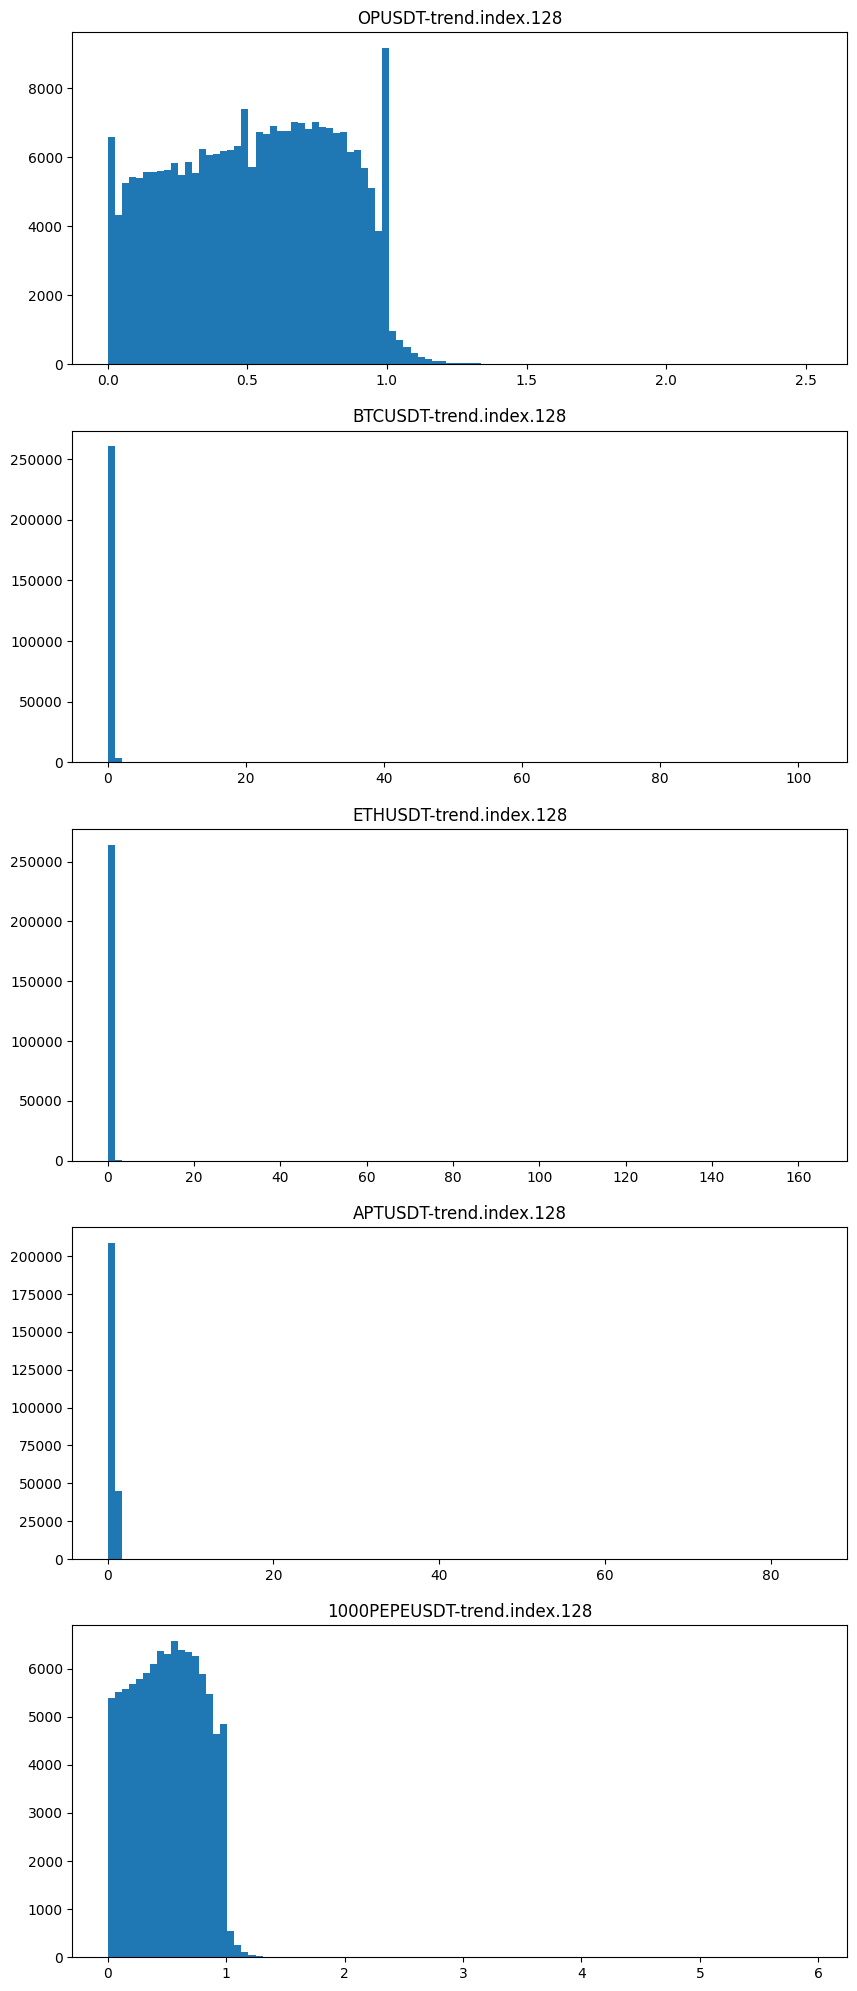

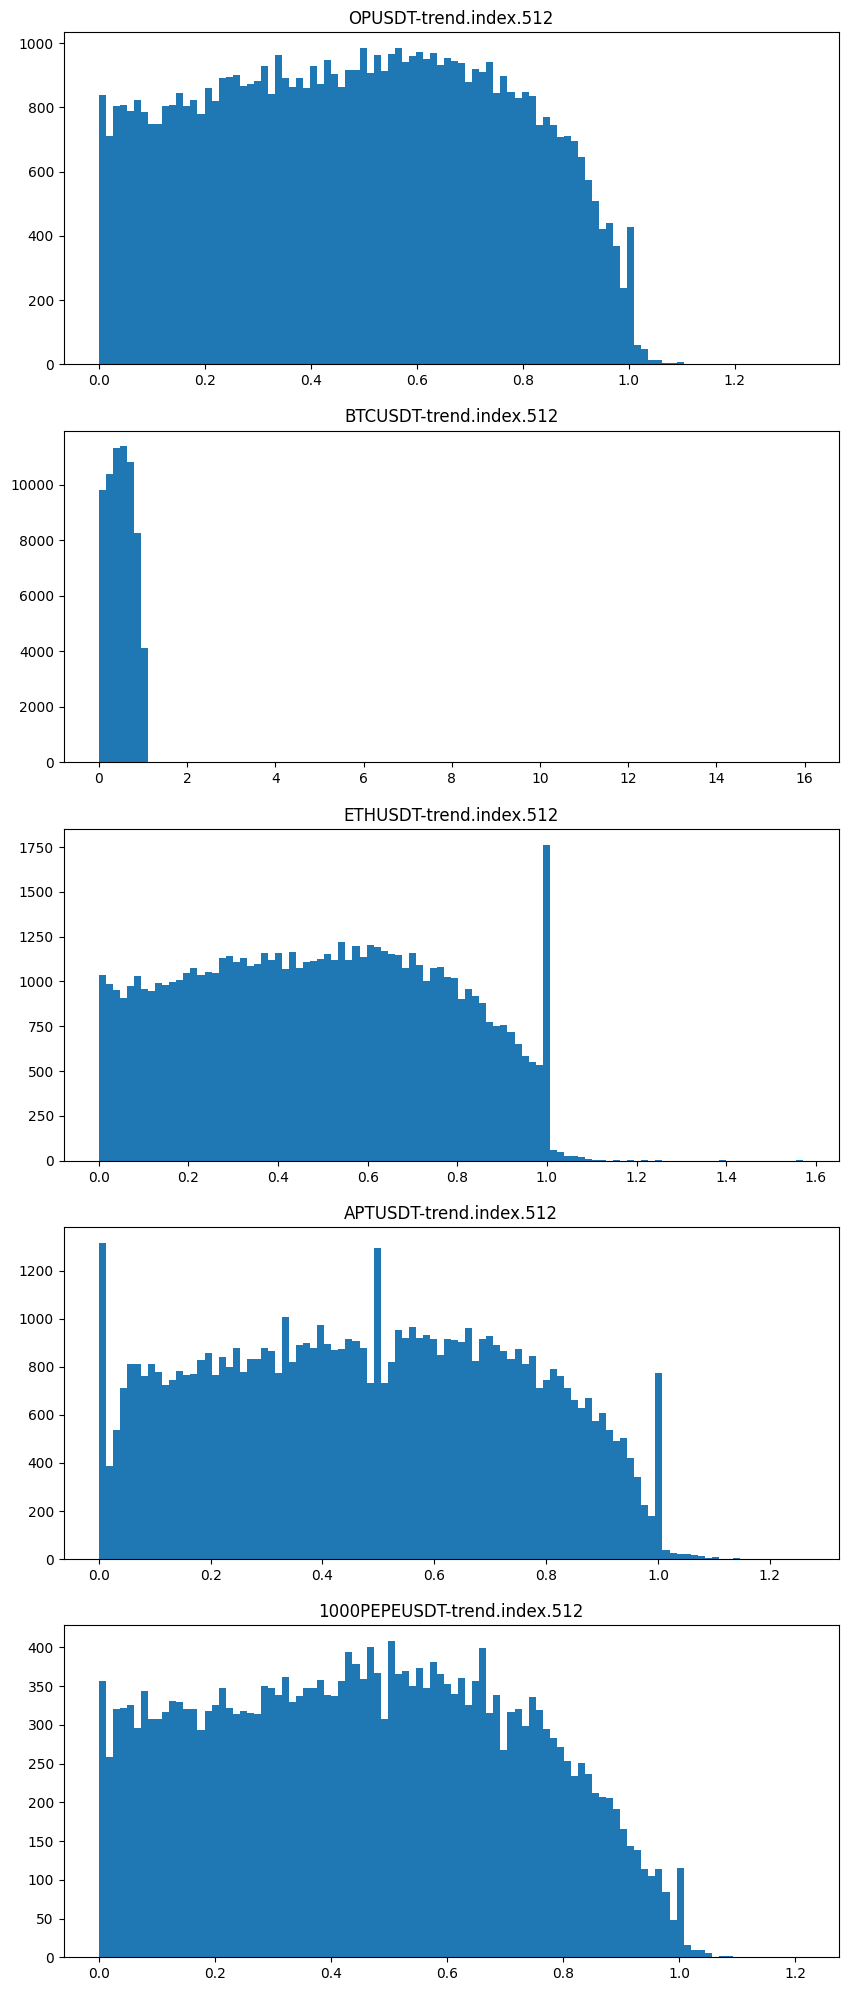

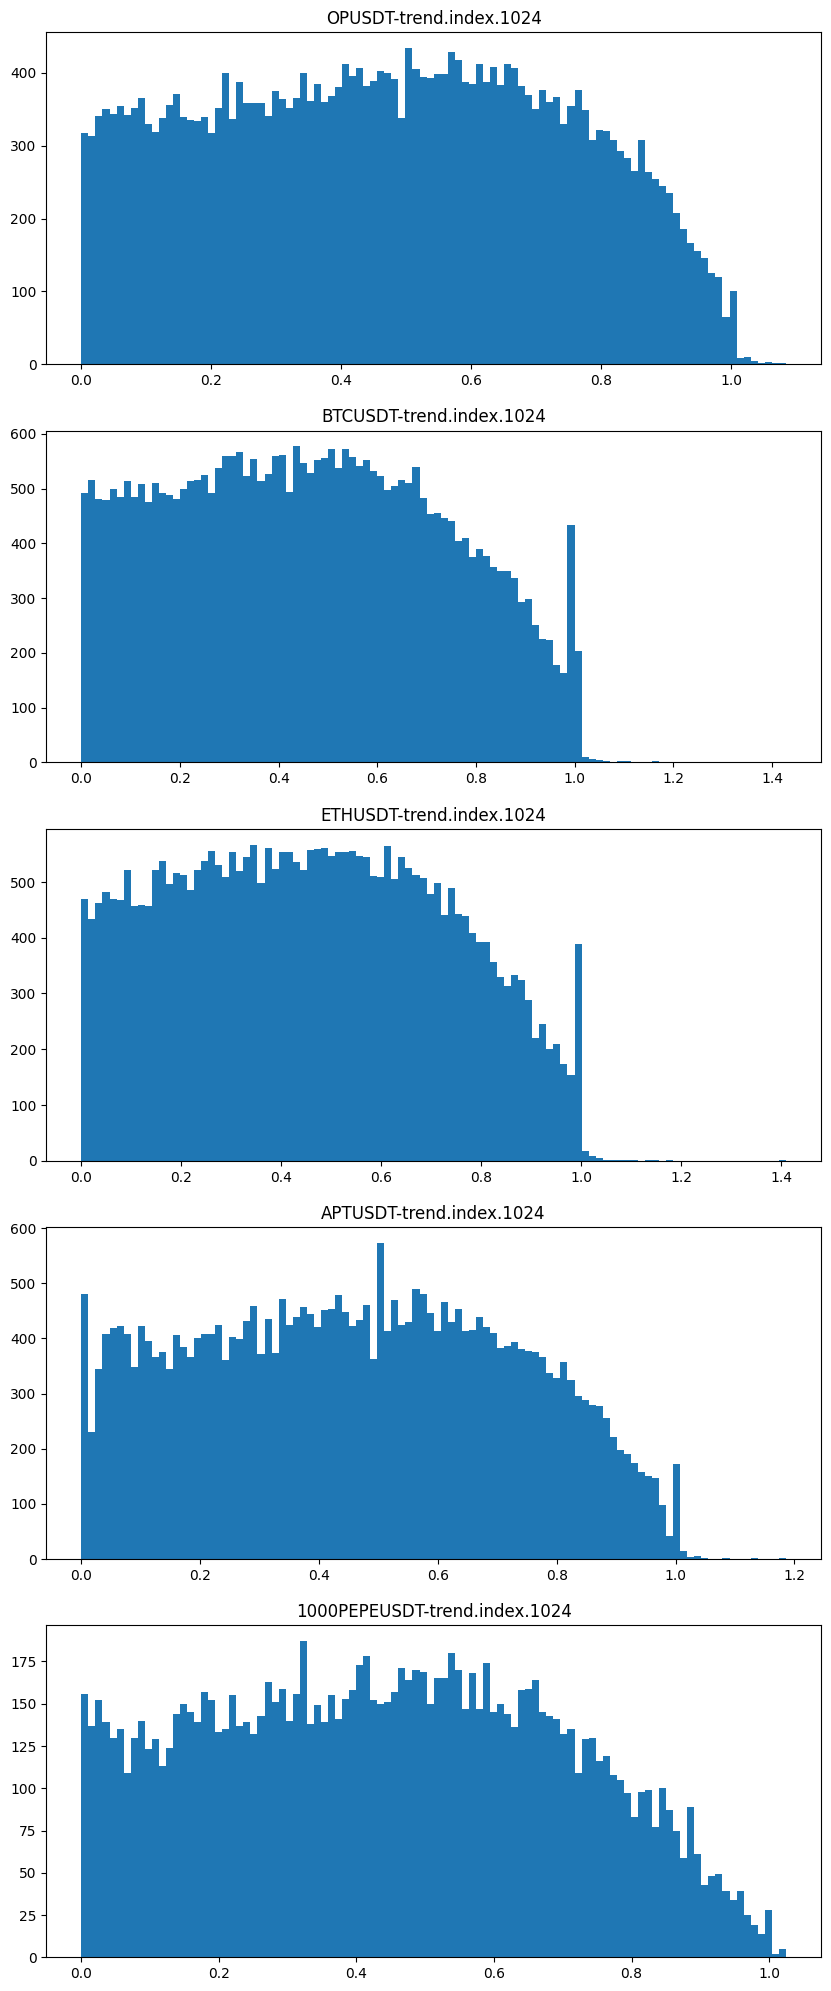

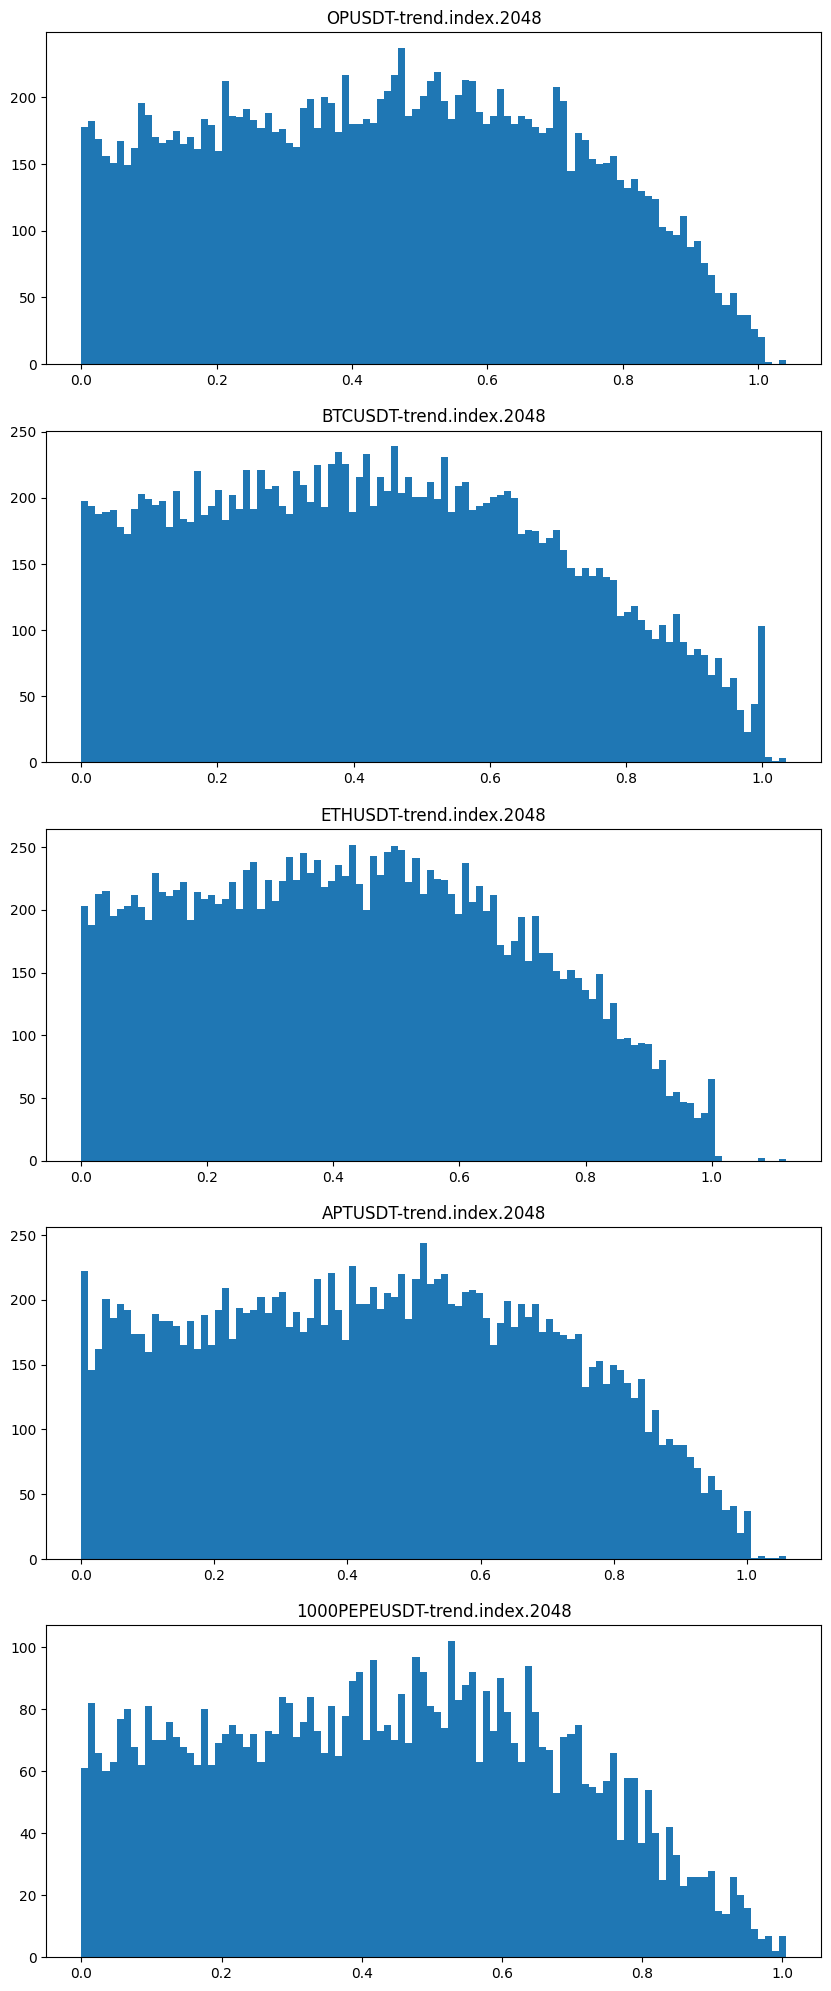

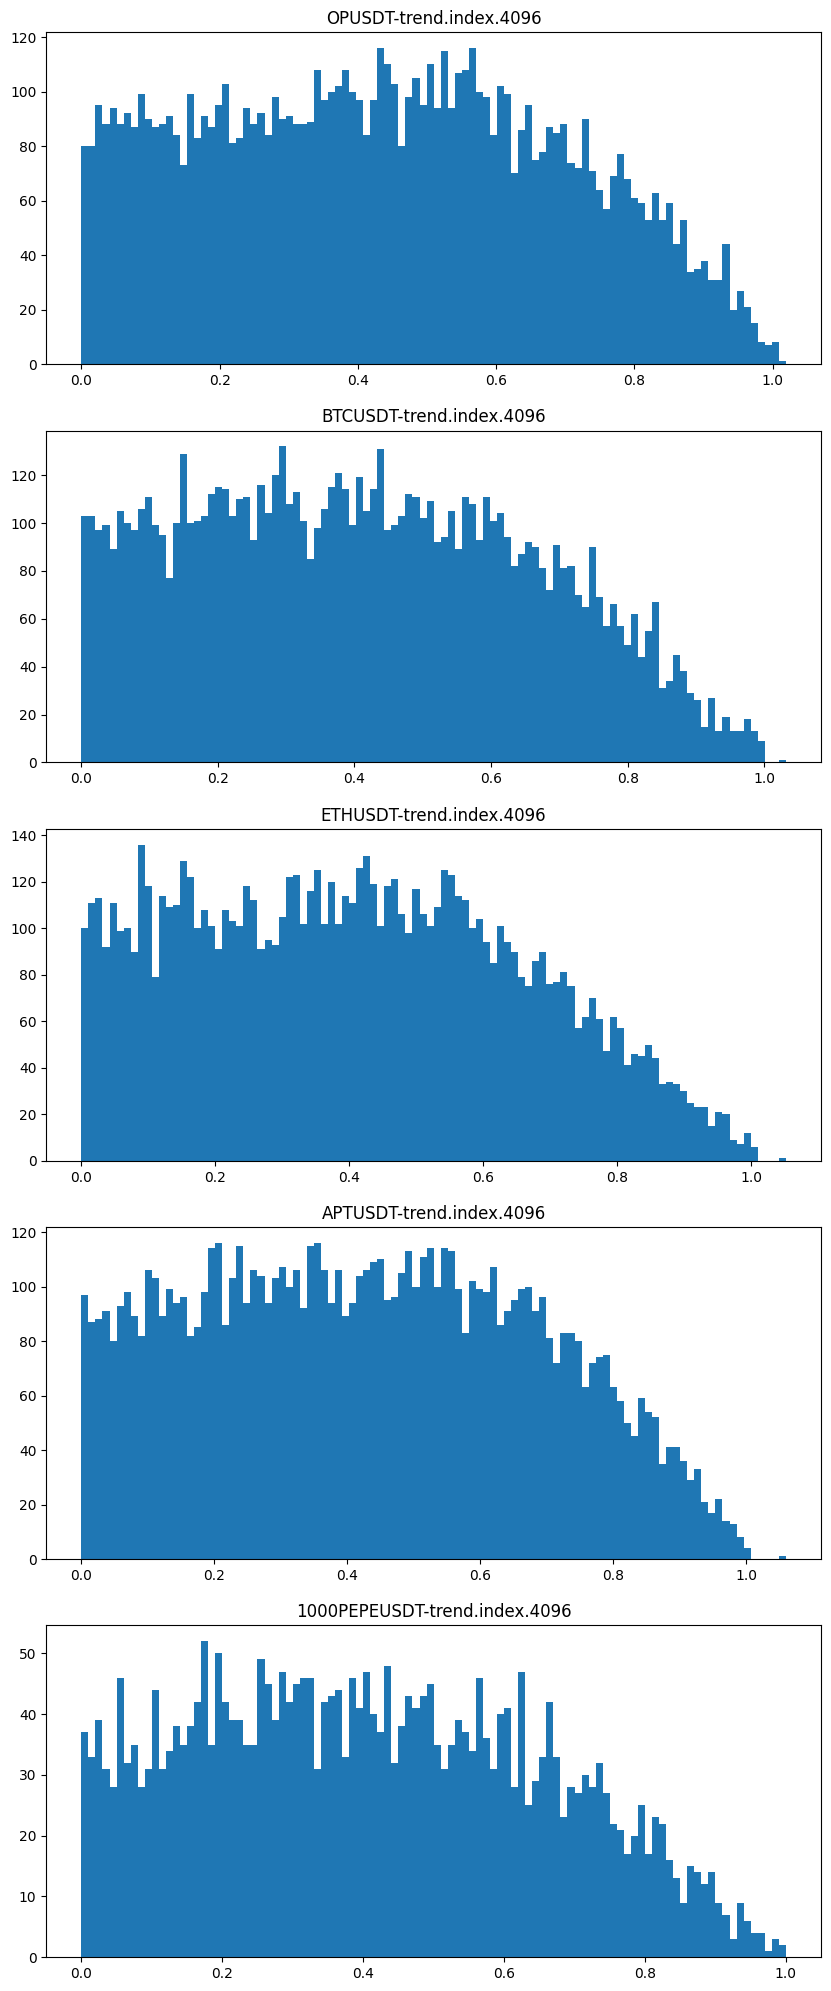

In [ ]:
import statsmodels.tsa.stattools as ts
# for period in periods:
period = 256
f, axes = plt.subplots(1, len(product_list), figsize=(10, 10))
signal_name = signal_name_format.format(period=period)
for i, product in enumerate(product_list):
    arr = all_product_signal_periods[period][product]
    T = len(arr)
    arr = arr[np.arange(0, T, period)]
    axes[i].hist(arr, bins=100)
    axes[i].set_title(product + "-" + signal_name)
f.show()

In [ ]:
from research.orderbook_strategies.utils.product_info import product_info
import traceback
from tqdm.notebook import tqdm
for period in tqdm(periods):
    for product in product_list:
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        all_dates = np.array(helper.get_dates_list(product))
        try:
            if product == "1000PEPEUSDT":
                split_str = "2023-06-10"
            else:
                split_str = "2023-04-01"
            signal = signal_name_format.format(period=period)
            signal = signal.replace(".{}".format(period), "")
            factor_analysis.evaluate_signal(signal, all_dates, product,
                                            period=period,
                                            split_str=split_str,
                                            tranct=tranct,
                                            max_spread=spread*1.1,
                                            tranct_ratio=tranct_ratio,
                                            atr_filter=0.01,
                                            save_path="signal_result_with_atr")
        except Exception as e:
            traceback.print_exc()
            print("Error in {}: {}".format(product, signal, period))

  0%|          | 0/6 [00:00<?, ?it/s]

done evaluate_signal trend ETHUSDT trend.index.64
done evaluate_signal reverse ETHUSDT trend.index.64
done evaluate_signal trend APTUSDT trend.index.64
done evaluate_signal reverse APTUSDT trend.index.64
done evaluate_signal trend 1000PEPEUSDT trend.index.64
done evaluate_signal reverse 1000PEPEUSDT trend.index.64
done evaluate_signal trend BTCUSDT trend.index.128
done evaluate_signal reverse BTCUSDT trend.index.128
done evaluate_signal trend ETHUSDT trend.index.128
done evaluate_signal reverse ETHUSDT trend.index.128
done evaluate_signal trend APTUSDT trend.index.128
done evaluate_signal reverse APTUSDT trend.index.128
done evaluate_signal trend 1000PEPEUSDT trend.index.128
done evaluate_signal reverse 1000PEPEUSDT trend.index.128
done evaluate_signal trend BTCUSDT trend.index.512
done evaluate_signal reverse BTCUSDT trend.index.512
done evaluate_signal trend ETHUSDT trend.index.512
done evaluate_signal reverse ETHUSDT trend.index.512


KeyboardInterrupt: 

In [ ]:
final_result = train_stat["final.result"]

In [ ]:
total_dfs = []
for product in train_stat_by_product:
    for reverse in train_stat_by_product[product]:
        data = train_stat_by_product[product][reverse]["result"]["final.result"]
        data["reverse"] = reverse
        data["product"] = product
        total_dfs.append(data)
total_df = pd.concat(total_dfs, axis=0)

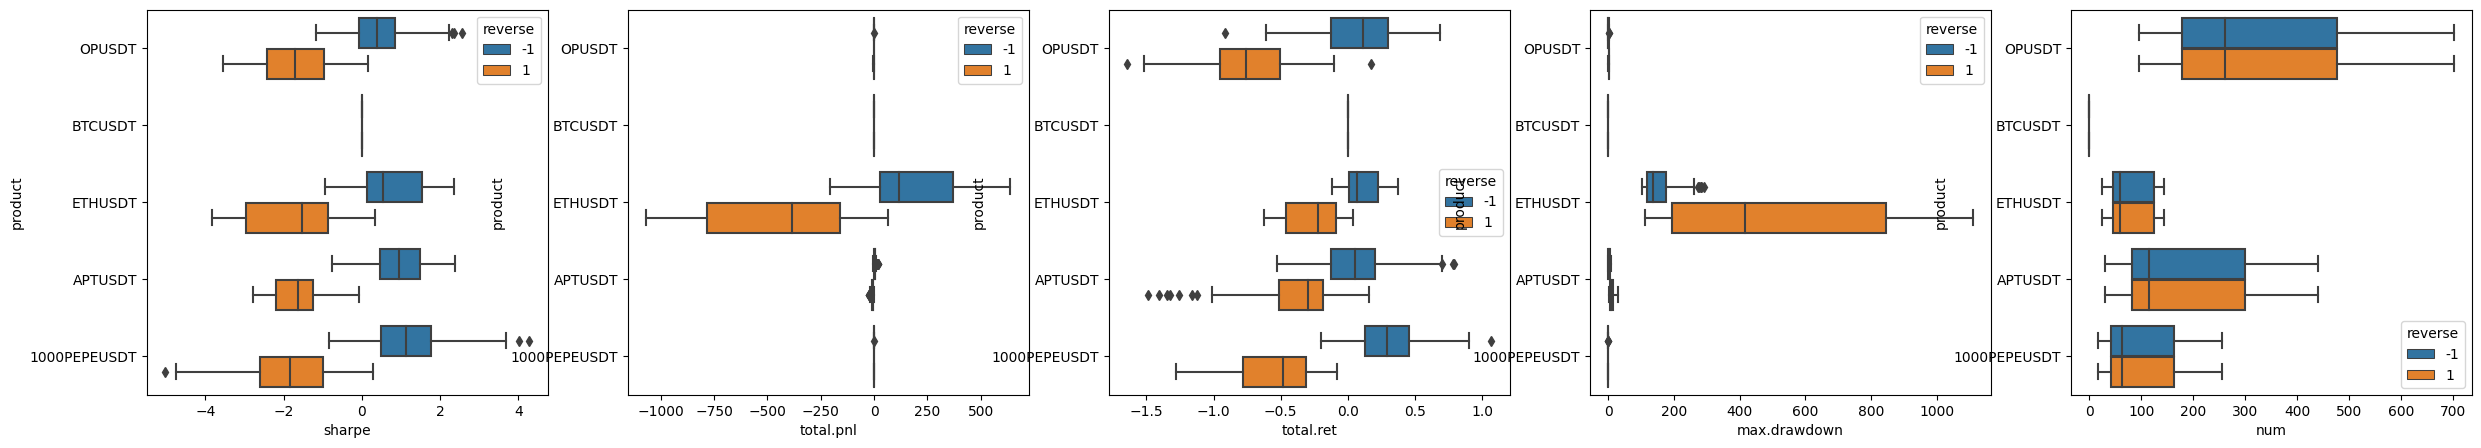

In [ ]:
import seaborn as sns
data = pd.DataFrame()

names = ["sharpe", "total.pnl", "total.ret", "max.drawdown", "num"]
f, axes = plt.subplots(1, len(names), figsize=(30, 5))
for i, ax in enumerate(axes):
    sns.boxplot(data=total_df, x=names[i], y="product", hue="reverse", ax=ax)

In [ ]:
total_df

,open,close,num,avg.num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret,reverse,product
open_close,,,,,,,,,,,,,,,,,,
0.031189123522770923_-0.006237824704554185,0.031189,-0.006238,700.5,3.433824,0.000367,0.256786,0.219432,0.505963,0.812917,-0.000129,-0.090405,-0.164167,0.242348,0.391121,0.315883,-0.231144,reverse,product
0.031189123522770923_-0.01247564940910837,0.031189,-0.012476,660.5,3.237745,0.001152,0.760899,0.601165,0.029994,0.966461,0.000342,0.225608,0.388289,0.029661,0.438093,0.787304,0.514977,reverse,product
0.031189123522770923_-0.018713474113662552,0.031189,-0.018713,611.5,2.997549,0.002205,1.348235,1.022779,0.016264,0.907176,0.000803,0.491222,0.801793,0.020804,0.485802,1.486189,1.011156,reverse,product
0.031189123522770923_-0.02495129881821674,0.031189,-0.024951,551.0,2.700980,0.000754,0.415355,0.293609,0.055693,0.875870,-0.000015,-0.008500,-0.012910,0.077874,0.463921,0.474220,-0.018321,reverse,product
0.031189123522770923_-0.031189123522770923,0.031189,-0.031189,506.5,2.482843,0.001861,0.942780,0.581150,0.000000,0.987213,0.000349,0.176609,0.239718,0.000000,0.460859,0.954992,0.383216,reverse,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.12859198078301526_-0.025718396156603054,0.128592,-0.025718,18.0,0.222222,-0.000021,-0.000369,-4.220836,0.000369,0.000369,-0.017427,-0.313694,-4.175053,0.313694,0.313694,-1.000000,-1.000000,reverse,product
0.12859198078301526_-0.05143679231320611,0.128592,-0.051437,17.0,0.209877,-0.000024,-0.000410,-2.643341,0.000410,0.000429,-0.022644,-0.384944,-2.901423,0.384944,0.387145,-0.955984,-0.994315,reverse,product
0.12859198078301526_-0.07715518846980915,0.128592,-0.077155,17.0,0.209877,-0.000019,-0.000319,-2.277630,0.000319,0.000354,-0.017219,-0.292717,-2.675648,0.292717,0.309425,-0.901225,-0.946005,reverse,product
